In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionResNetV2(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 1536)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [9]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min


[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 1.4min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 1.4min
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.4min
[CV] C=0.01, gamma=0.001 .............................................
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 1.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 1.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.5min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.7min


[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505718, total= 1.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 1.5min
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 1.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 1.5min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 1.5min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 1.5min
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 1.5min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min


[CV] ............... C=0.01, gamma=0.01, score=0.858958, total= 1.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.862595, total= 1.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.890585, total= 1.1min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.849873, total= 1.1min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.874046, total= 1.1min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.869123, total= 1.2min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.867684, total= 1.2min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min


[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505718, total= 1.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505718, total= 1.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  7.2min


[CV] ............... C=0.1, gamma=1e-08, score=0.505718, total= 1.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.5min
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505718, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total= 1.4min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  8.0min


[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 1.5min
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=1.0 ................................................
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 1.5min
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.896947, total=  37.3s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  8.6min


[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.891858, total=  35.6s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.888041, total= 1.1min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.866412, total= 1.1min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.868957, total= 1.1min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.602287, total= 1.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.615776, total= 1.4min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.618321, total= 1.4min
[CV] C

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 11.0min


[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 1.4min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505718, total= 1.4min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 1.5min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 1.4min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 1.5min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 12.0min


[CV] .............. C=1.0, gamma=0.0001, score=0.908397, total=  35.9s
[CV] C=1.0, gamma=0.1 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.909669, total=  35.8s
[CV] C=1.0, gamma=0.1 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.912214, total=  35.9s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.922392, total=  22.7s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.923664, total=  37.0s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.947903, total=  29.4s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.950382, total=  30.1s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 13.2min


[CV] ............... C=1.0, gamma=1e-06, score=0.505089, total= 1.5min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.505089, total= 1.5min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.837150, total= 1.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.853690, total= 1.3min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.832274, total= 1.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.849873, total= 1.3min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.819338, total= 1.3min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 15.4min


[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.919949, total=  35.5s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] .............. C=10.0, gamma=1e-05, score=0.907125, total=  35.5s
[CV] C=10.0, gamma=0.001 .............................................
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505718, total= 1.4min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 1.4min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 16.3min


[CV] .............. C=10.0, gamma=1e-05, score=0.908397, total=  35.7s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.862770, total= 1.1min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.857506, total= 1.1min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.866412, total= 1.1min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.886768, total= 1.1min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.867684, total= 1.1min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.01, score=0.954257, total=  31.3s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 18.8min


[CV] ............. C=100.0, gamma=1e-07, score=0.857506, total= 1.1min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.545108, total= 1.4min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.886768, total= 1.1min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.680662, total= 1.4min
[CV] ............. C=100.0, gamma=1e-07, score=0.862770, total= 1.1min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.559796, total= 1.4min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.555980, total= 1.4min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 19.4min


[CV] ............. C=100.0, gamma=1e-06, score=0.919949, total=  36.7s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.907125, total=  37.3s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=0.001, score=0.949109, total=  19.1s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.924936, total=  36.2s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.922392, total=  22.8s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.931298, total=  24.0s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.947837, total=  24.3s
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 21.7min


[CV] ............... C=100.0, gamma=0.1, score=0.848601, total= 1.4min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.867684, total= 1.4min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.857506, total= 1.2min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.847522, total= 1.5min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.858779, total= 1.4min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.886768, total= 1.2min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.829517, total= 1.5min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 23.0min remaining:  1.3min


[CV] ............. C=1000.0, gamma=0.01, score=0.970738, total=  31.4s
[CV] .............. C=1000.0, gamma=0.1, score=0.867684, total= 1.0min
[CV] .............. C=1000.0, gamma=0.1, score=0.847522, total= 1.1min
[CV] .............. C=1000.0, gamma=1.0, score=0.593393, total=  58.8s
[CV] .............. C=1000.0, gamma=1.0, score=0.600509, total=  57.2s
[CV] .............. C=1000.0, gamma=1.0, score=0.610687, total=  58.3s
[CV] .............. C=1000.0, gamma=0.1, score=0.848601, total= 1.2min
[CV] .............. C=1000.0, gamma=1.0, score=0.680662, total= 1.0min
[CV] .............. C=1000.0, gamma=0.1, score=0.829517, total= 1.2min
[CV] .............. C=1000.0, gamma=0.1, score=0.858779, total= 1.2min
[CV] .............. C=1000.0, gamma=1.0, score=0.620865, total= 1.2min
[CV] ............. C=1000.0, gamma=10.0, score=0.545108, total= 1.1min
[CV] ............. C=1000.0, gamma=10.0, score=0.559796, total= 1.1min
[CV] ............. C=1000.0, gamma=10.0, score=0.555980, total= 1.1min
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
top_model.cv_results_

{'mean_fit_time': array([69.08698301, 70.61526351, 71.63017058, 69.72828088, 72.76888509,
        60.15348034, 52.89496298, 70.05140519, 71.22550468, 70.10064716,
        69.73925748, 69.90910392, 70.66759424, 70.63333602, 55.42829032,
        31.12896442, 28.6574821 , 67.1294117 , 70.56490254, 68.86109385,
        69.33114057, 69.07583098, 70.26986985, 56.00054293, 29.18695064,
        19.46167636, 23.96058922, 64.83237143, 67.60120382, 68.19354959,
        68.60349331, 68.62220244, 53.45867963, 28.96289148, 19.13082314,
        15.60440512, 26.14999094, 69.97692776, 68.40428996, 68.14153938,
        67.84548678, 54.04742322, 29.33492436, 19.47749681, 15.19897151,
        15.88771281, 25.51344748, 70.28593931, 69.9884335 , 68.26810236,
        54.89211621, 29.24130917, 19.16182051, 15.37200232, 15.58438339,
        14.73690805, 25.69362903, 58.79668498, 51.40132089, 56.04606948]),
 'mean_score_time': array([17.69671183, 17.66423087, 17.5006351 , 17.30566874, 17.67893295,
        14.80

In [11]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-06},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-05},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.86899, std: 0.00976, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.86721, std: 0.01402, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.1},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-06},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-05},
 mean: 0.86848, std: 0.01067, params: {'C': 0.1, 'gamma': 0.0001},
 mea

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.01} - score: 0.9580


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


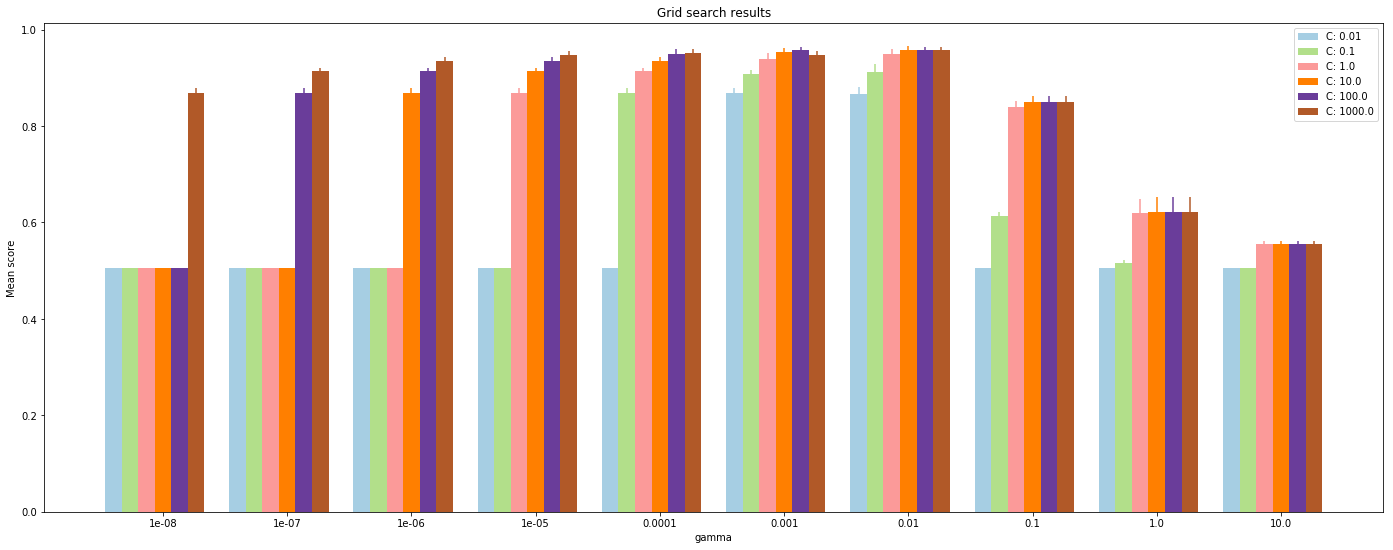

In [13]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()